<a href="https://colab.research.google.com/github/aniket-alt/CMPE-258-Deep-Learning/blob/main/Assignment%20-%203/colab_a_numpy_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab a) 3-Layer Deep Neural Network using NumPy from Scratch

**CMPE 258 - Deep Learning Assignment**

## Objective
Implement a 3-layer deep neural network for non-linear regression using **only NumPy** (with `tf.einsum` for matrix operations). This implementation includes:
- Manual forward propagation
- Manual backpropagation using chain rule
- Gradient-based optimization
- 4D visualization of results

## Target Function
$$y = \sin(x_1) \cdot \cos(x_2) + x_3^2 + 0.5 \cdot x_1 \cdot x_2$$

## Network Architecture
```
Input (3) → Hidden1 (64, Tanh) → Hidden2 (32, Tanh) → Output (1)
```

## 1. Import Libraries

We import NumPy for numerical operations, TensorFlow only for `tf.einsum` (efficient matrix multiplication), matplotlib for visualization, and scikit-learn for PCA dimensionality reduction.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

NumPy version: 2.0.2
TensorFlow version: 2.19.0


## 2. Define the Target Non-Linear Function

This is the ground truth function our neural network will learn to approximate. It takes 3 input variables and produces 1 output. The function combines trigonometric, polynomial, and interaction terms to create a complex non-linear relationship.

In [2]:
def target_function(x1, x2, x3):
    """
    Non-linear target function with 3 variables:
    y = sin(x1) * cos(x2) + x3^2 + 0.5 * x1 * x2

    This function combines:
    - Trigonometric non-linearity: sin(x1), cos(x2)
    - Polynomial non-linearity: x3^2
    - Variable interaction: x1 * x2
    """
    return np.sin(x1) * np.cos(x2) + x3**2 + 0.5 * x1 * x2

# Test the function
print("Function test: f(1, 1, 1) =", target_function(1, 1, 1))

Function test: f(1, 1, 1) = 1.954648713412841


## 3. Generate Synthetic Training Data

We create synthetic data by sampling random points in a defined range and computing the target function values. A small amount of noise is added to simulate real-world data imperfections.

In [3]:
def generate_data(n_samples=2000, noise_std=0.05):
    """
    Generate synthetic data for training and testing.

    Args:
        n_samples: Number of data points to generate
        noise_std: Standard deviation of Gaussian noise added to outputs

    Returns:
        X: Input features of shape (n_samples, 3)
        y: Target values of shape (n_samples, 1)
    """
    # Generate random inputs in range [-2, 2]
    x1 = np.random.uniform(-2, 2, n_samples)
    x2 = np.random.uniform(-2, 2, n_samples)
    x3 = np.random.uniform(-2, 2, n_samples)

    # Stack into feature matrix
    X = np.column_stack([x1, x2, x3])

    # Compute target values with noise
    y = target_function(x1, x2, x3) + np.random.normal(0, noise_std, n_samples)
    y = y.reshape(-1, 1)

    return X, y

# Generate training and test data
X_train, y_train = generate_data(n_samples=2000)
X_test, y_test = generate_data(n_samples=500)

print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)
print("\nSample input (first 3 rows):")
print(X_train[:3])
print("\nSample output (first 3 values):")
print(y_train[:3].flatten())

Training data shape: (2000, 3) (2000, 1)
Test data shape: (500, 3) (500, 1)

Sample input (first 3 rows):
[[-0.50183952 -0.95317727  0.28798351]
 [ 1.80285723 -1.0120848   1.22172932]
 [ 0.92797577  1.62501832  1.04064372]]

Sample output (first 3 values):
[-0.0087682   1.11985534  1.80809707]


## 4. Define Activation Functions and Their Derivatives

For backpropagation, we need both the activation function and its derivative. We use **Tanh** as the primary activation function because it outputs values in the range [-1, 1], which works well for our regression task. ReLU is also implemented as an alternative.

In [4]:
def tanh(x):
    """Hyperbolic tangent activation function."""
    return np.tanh(x)

def tanh_derivative(x):
    """Derivative of tanh: 1 - tanh(x)^2"""
    return 1 - np.tanh(x)**2

def relu(x):
    """Rectified Linear Unit activation function."""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    return (x > 0).astype(float)

# Test activation functions
test_input = np.array([-2, -1, 0, 1, 2])
print("Test input:", test_input)
print("Tanh output:", tanh(test_input))
print("Tanh derivative:", tanh_derivative(test_input))

Test input: [-2 -1  0  1  2]
Tanh output: [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]
Tanh derivative: [0.07065082 0.41997434 1.         0.41997434 0.07065082]


## 5. Neural Network Class Definition

This is the core implementation of our 3-layer neural network from scratch. Key components:

- **Weight Initialization**: Using Xavier/He initialization for better convergence
- **Forward Propagation**: Computing activations layer by layer using `tf.einsum`
- **Backward Propagation**: Computing gradients using chain rule
- **Parameter Update**: Gradient descent optimization

In [5]:
class NeuralNetworkNumPy:
    """
    3-Layer Deep Neural Network implemented from scratch using NumPy.
    Uses tf.einsum for matrix multiplication operations.

    Architecture: Input(3) -> Hidden1(64) -> Hidden2(32) -> Output(1)
    """

    def __init__(self, input_size=3, hidden1_size=64, hidden2_size=32, output_size=1):
        """
        Initialize the neural network with random weights.

        Uses Xavier initialization: weights ~ N(0, sqrt(2/(fan_in + fan_out)))
        """
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size

        # Xavier initialization for weights
        # Layer 1: Input -> Hidden1
        self.W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2.0 / (input_size + hidden1_size))
        self.b1 = np.zeros((1, hidden1_size))

        # Layer 2: Hidden1 -> Hidden2
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2.0 / (hidden1_size + hidden2_size))
        self.b2 = np.zeros((1, hidden2_size))

        # Layer 3: Hidden2 -> Output
        self.W3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2.0 / (hidden2_size + output_size))
        self.b3 = np.zeros((1, output_size))

        # Cache for storing intermediate values during forward pass (needed for backprop)
        self.cache = {}

        print(f"Neural Network Initialized:")
        print(f"  Layer 1: {input_size} -> {hidden1_size} (W1: {self.W1.shape}, b1: {self.b1.shape})")
        print(f"  Layer 2: {hidden1_size} -> {hidden2_size} (W2: {self.W2.shape}, b2: {self.b2.shape})")
        print(f"  Layer 3: {hidden2_size} -> {output_size} (W3: {self.W3.shape}, b3: {self.b3.shape})")
        total_params = (input_size * hidden1_size + hidden1_size +
                       hidden1_size * hidden2_size + hidden2_size +
                       hidden2_size * output_size + output_size)
        print(f"  Total parameters: {total_params}")

    def forward(self, X):
        """
        Forward propagation through the network.

        Uses tf.einsum for matrix multiplication:
        'ij,jk->ik' means: (batch, input) x (input, output) -> (batch, output)

        Args:
            X: Input data of shape (batch_size, input_size)

        Returns:
            output: Predictions of shape (batch_size, output_size)
        """
        # Store input for backprop
        self.cache['X'] = X

        # Layer 1: Linear transformation + Tanh activation
        # z1 = X @ W1 + b1
        self.cache['z1'] = tf.einsum('ij,jk->ik', X, self.W1).numpy() + self.b1
        self.cache['a1'] = tanh(self.cache['z1'])

        # Layer 2: Linear transformation + Tanh activation
        # z2 = a1 @ W2 + b2
        self.cache['z2'] = tf.einsum('ij,jk->ik', self.cache['a1'], self.W2).numpy() + self.b2
        self.cache['a2'] = tanh(self.cache['z2'])

        # Layer 3: Linear transformation (no activation for regression output)
        # z3 = a2 @ W3 + b3
        self.cache['z3'] = tf.einsum('ij,jk->ik', self.cache['a2'], self.W3).numpy() + self.b3
        output = self.cache['z3']  # Linear output for regression

        return output

    def backward(self, y_true, y_pred, learning_rate=0.01):
        """
        Backward propagation using chain rule to compute gradients.

        For MSE loss: L = (1/2n) * sum((y_pred - y_true)^2)
        dL/dy_pred = (y_pred - y_true) / n

        Chain rule application:
        dL/dW3 = dL/dz3 * dz3/dW3 = dL/dz3 * a2^T
        dL/dW2 = dL/dz2 * dz2/dW2 = dL/dz2 * a1^T
        dL/dW1 = dL/dz1 * dz1/dW1 = dL/dz1 * X^T

        Args:
            y_true: Ground truth values
            y_pred: Predicted values
            learning_rate: Step size for gradient descent
        """
        m = y_true.shape[0]  # Batch size

        # Output layer gradient
        # dL/dz3 = (y_pred - y_true) / m (for MSE loss with linear output)
        dz3 = (y_pred - y_true) / m

        # Gradients for Layer 3
        # dW3 = a2^T @ dz3
        dW3 = tf.einsum('ij,ik->jk', self.cache['a2'], dz3).numpy()
        db3 = np.sum(dz3, axis=0, keepdims=True)

        # Backpropagate to Layer 2
        # da2 = dz3 @ W3^T
        da2 = tf.einsum('ij,kj->ik', dz3, self.W3).numpy()
        # dz2 = da2 * tanh'(z2)
        dz2 = da2 * tanh_derivative(self.cache['z2'])

        # Gradients for Layer 2
        dW2 = tf.einsum('ij,ik->jk', self.cache['a1'], dz2).numpy()
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # Backpropagate to Layer 1
        da1 = tf.einsum('ij,kj->ik', dz2, self.W2).numpy()
        dz1 = da1 * tanh_derivative(self.cache['z1'])

        # Gradients for Layer 1
        dW1 = tf.einsum('ij,ik->jk', self.cache['X'], dz1).numpy()
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # Update weights and biases using gradient descent
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def compute_loss(self, y_true, y_pred):
        """
        Compute Mean Squared Error loss.

        MSE = (1/n) * sum((y_pred - y_true)^2)
        """
        return np.mean((y_pred - y_true)**2)

# Initialize the network
nn = NeuralNetworkNumPy()

Neural Network Initialized:
  Layer 1: 3 -> 64 (W1: (3, 64), b1: (1, 64))
  Layer 2: 64 -> 32 (W2: (64, 32), b2: (1, 32))
  Layer 3: 32 -> 1 (W3: (32, 1), b3: (1, 1))
  Total parameters: 2369


## 6. Training Loop

The training process involves:
1. Forward pass: Compute predictions
2. Compute loss: MSE between predictions and targets
3. Backward pass: Compute gradients via chain rule
4. Update parameters: Apply gradient descent

We train for multiple epochs and track the loss history for visualization.

In [6]:
def train_network(model, X_train, y_train, X_test, y_test,
                  epochs=1000, learning_rate=0.01, print_every=100):
    """
    Train the neural network using mini-batch gradient descent.

    Args:
        model: NeuralNetworkNumPy instance
        X_train, y_train: Training data
        X_test, y_test: Test data for evaluation
        epochs: Number of training iterations
        learning_rate: Step size for gradient descent
        print_every: Print progress every N epochs

    Returns:
        train_losses: List of training losses per epoch
        test_losses: List of test losses per epoch
    """
    train_losses = []
    test_losses = []

    print(f"Starting training for {epochs} epochs with learning rate {learning_rate}")
    print("=" * 60)

    for epoch in range(epochs):
        # Forward pass
        y_pred_train = model.forward(X_train)

        # Compute training loss
        train_loss = model.compute_loss(y_train, y_pred_train)
        train_losses.append(train_loss)

        # Backward pass and update
        model.backward(y_train, y_pred_train, learning_rate)

        # Compute test loss (without updating weights)
        y_pred_test = model.forward(X_test)
        test_loss = model.compute_loss(y_test, y_pred_test)
        test_losses.append(test_loss)

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d}/{epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

    print("=" * 60)
    print(f"Training complete! Final Train Loss: {train_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}")

    return train_losses, test_losses

# Train the network
train_losses, test_losses = train_network(
    nn, X_train, y_train, X_test, y_test,
    epochs=1000,
    learning_rate=0.05,
    print_every=100
)

Starting training for 1000 epochs with learning rate 0.05
Epoch    1/1000 | Train Loss: 3.904812 | Test Loss: 3.264561
Epoch  100/1000 | Train Loss: 1.515439 | Test Loss: 1.517211
Epoch  200/1000 | Train Loss: 0.462624 | Test Loss: 0.451893
Epoch  300/1000 | Train Loss: 0.240678 | Test Loss: 0.232946
Epoch  400/1000 | Train Loss: 0.136636 | Test Loss: 0.132892
Epoch  500/1000 | Train Loss: 0.081461 | Test Loss: 0.079718
Epoch  600/1000 | Train Loss: 0.059530 | Test Loss: 0.058436
Epoch  700/1000 | Train Loss: 0.047127 | Test Loss: 0.046261
Epoch  800/1000 | Train Loss: 0.038530 | Test Loss: 0.037752
Epoch  900/1000 | Train Loss: 2.053503 | Test Loss: 2.093811
Epoch 1000/1000 | Train Loss: 0.034004 | Test Loss: 0.032960
Training complete! Final Train Loss: 0.034004, Test Loss: 0.032960


## 7. Visualize Training Progress

Plotting the loss curves helps us understand if the model is learning properly and whether it's overfitting (train loss decreasing but test loss increasing).

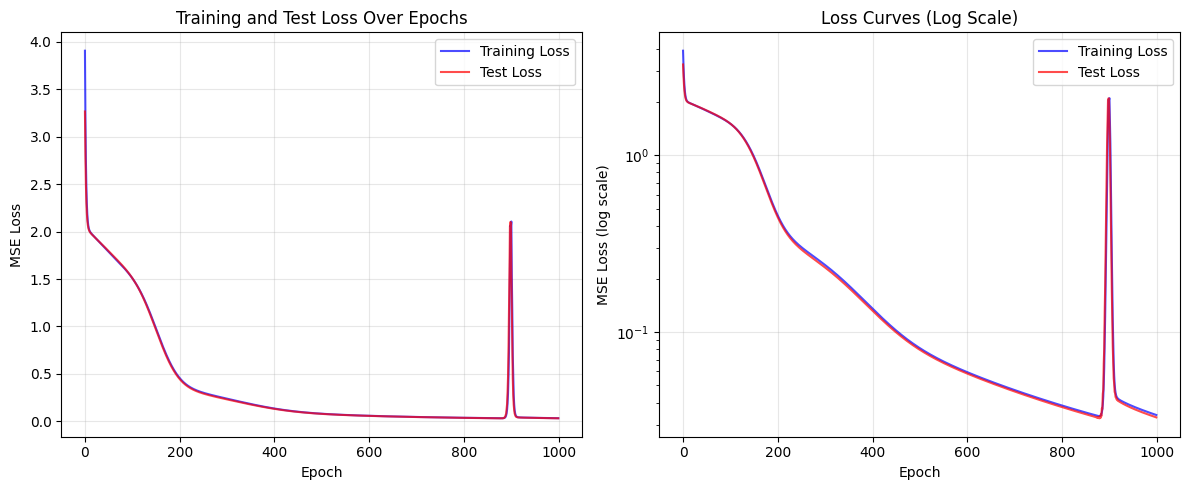

In [7]:
def plot_loss_curves(train_losses, test_losses):
    """
    Plot training and test loss curves.
    """
    plt.figure(figsize=(12, 5))

    # Plot 1: Full loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Log scale for better visualization
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (log scale)')
    plt.title('Loss Curves (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_loss_curves(train_losses, test_losses)

## 8. Evaluate Model Performance

We compare predicted values against actual values to assess how well the model has learned the target function.

Model Evaluation Metrics:
  MSE (Mean Squared Error):  0.032960
  RMSE (Root MSE):           0.181550
  MAE (Mean Absolute Error): 0.135455
  R² Score:                  0.984329


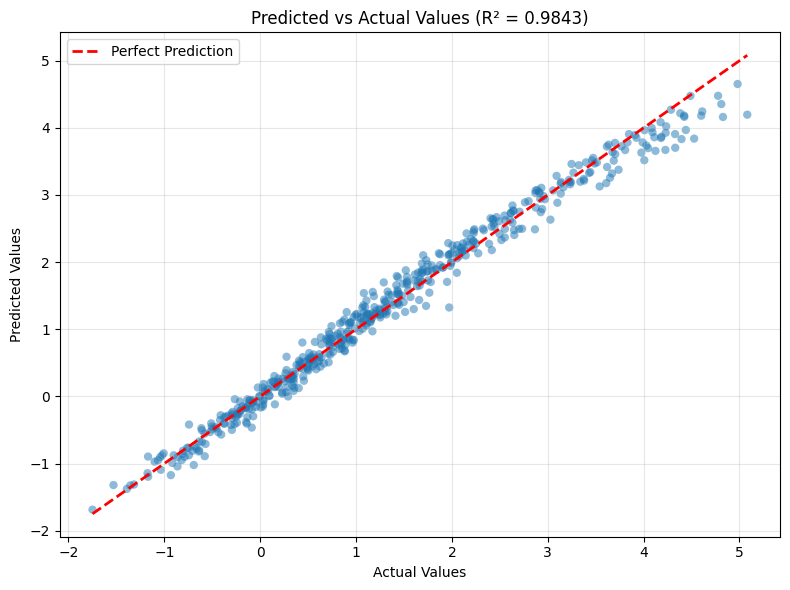

In [8]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance with various metrics.
    """
    # Get predictions
    y_pred = model.forward(X_test)

    # Calculate metrics
    mse = np.mean((y_pred - y_test)**2)
    mae = np.mean(np.abs(y_pred - y_test))
    rmse = np.sqrt(mse)

    # R-squared score
    ss_res = np.sum((y_test - y_pred)**2)
    ss_tot = np.sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (ss_res / ss_tot)

    print("Model Evaluation Metrics:")
    print(f"  MSE (Mean Squared Error):  {mse:.6f}")
    print(f"  RMSE (Root MSE):           {rmse:.6f}")
    print(f"  MAE (Mean Absolute Error): {mae:.6f}")
    print(f"  R² Score:                  {r2:.6f}")

    # Scatter plot of predicted vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='none')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Values (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return mse, rmse, mae, r2

metrics = evaluate_model(nn, X_test, y_test)

## 9. 4D Visualization using PCA

Since we have 3 input variables and 1 output, we need a way to visualize this 4-dimensional relationship. We use two approaches:

1. **Direct 3D Plot**: Use x1, x2, x3 as axes and color to represent the output
2. **PCA-based Plot**: Reduce 3 inputs to 2 principal components, use the 3rd axis for output

The PCA approach helps reveal the underlying structure of the data in a more interpretable way.

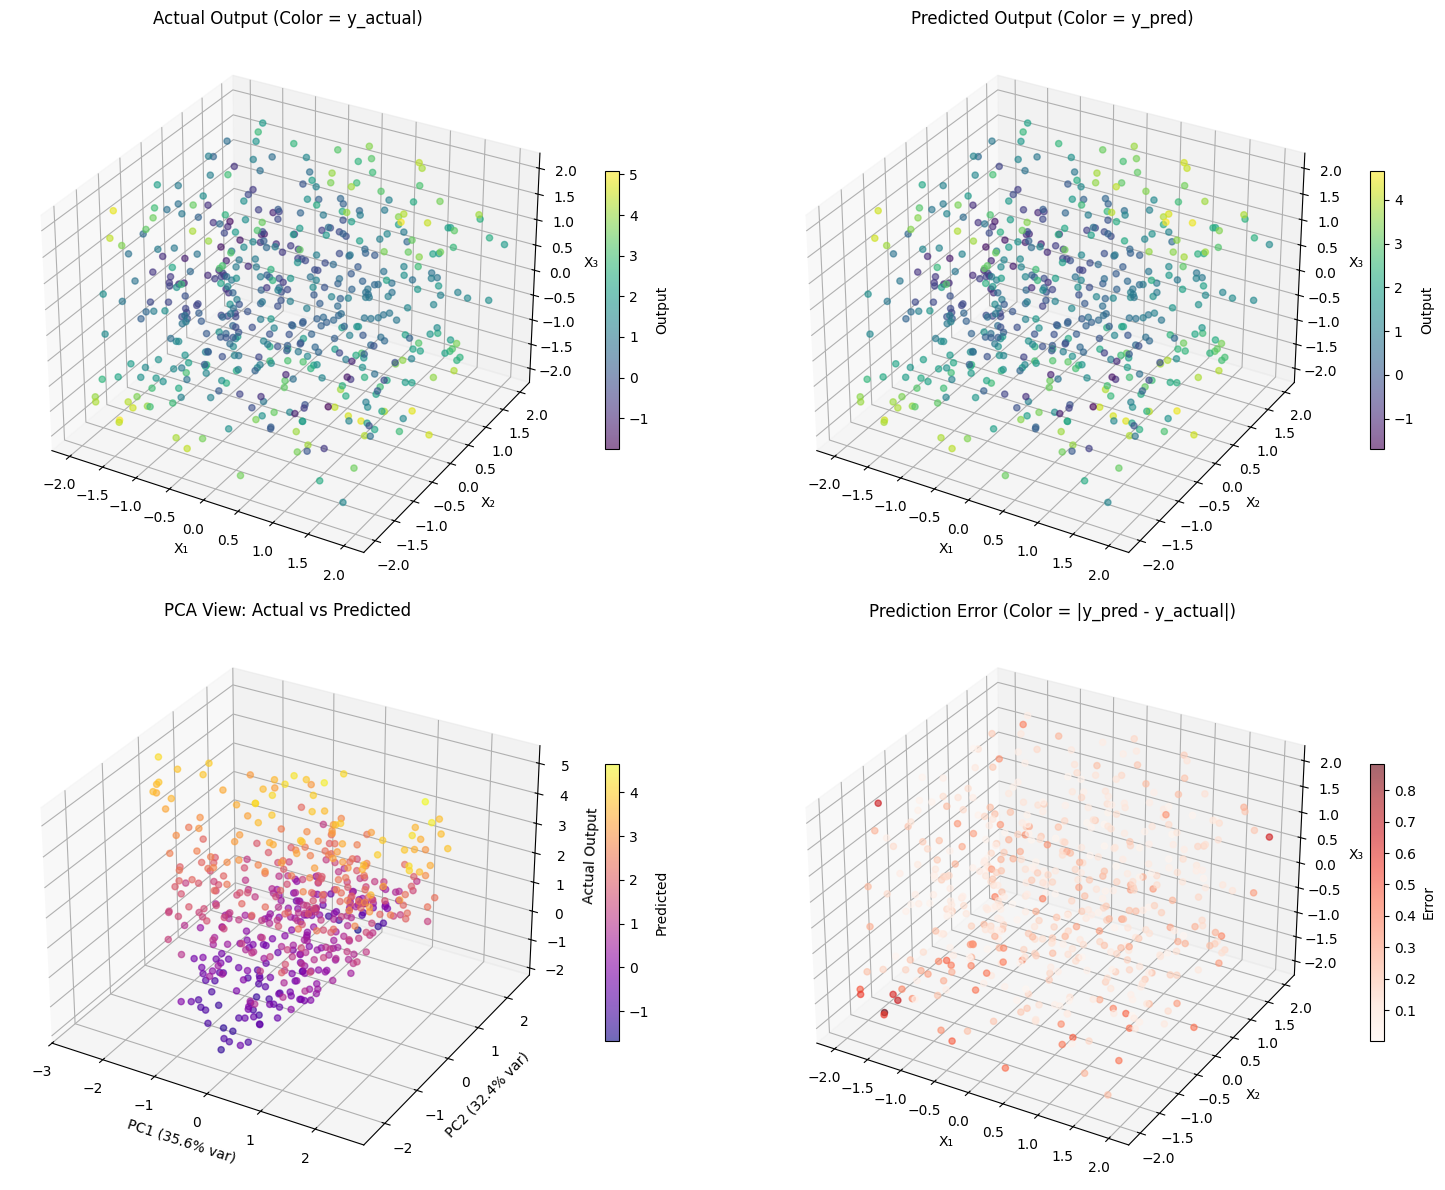


PCA Explained Variance Ratio: [0.35560744 0.32382292]
Total Variance Explained: 67.9%


In [9]:
def plot_4d_visualization(model, X_test, y_test):
    """
    Create 4D visualizations of the neural network predictions.

    Method 1: 3D scatter with color representing output
    Method 2: PCA-reduced visualization
    """
    # Get predictions
    y_pred = model.forward(X_test).flatten()
    y_actual = y_test.flatten()

    fig = plt.figure(figsize=(16, 12))

    # ===== Plot 1: Direct 3D with color for actual output =====
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    scatter1 = ax1.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                          c=y_actual, cmap='viridis', alpha=0.6, s=20)
    ax1.set_xlabel('X₁')
    ax1.set_ylabel('X₂')
    ax1.set_zlabel('X₃')
    ax1.set_title('Actual Output (Color = y_actual)')
    plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='Output')

    # ===== Plot 2: Direct 3D with color for predicted output =====
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    scatter2 = ax2.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                          c=y_pred, cmap='viridis', alpha=0.6, s=20)
    ax2.set_xlabel('X₁')
    ax2.set_ylabel('X₂')
    ax2.set_zlabel('X₃')
    ax2.set_title('Predicted Output (Color = y_pred)')
    plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Output')

    # ===== Plot 3: PCA-based visualization =====
    # Apply PCA to reduce 3D input to 2D
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_test)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], y_actual,
                          c=y_pred, cmap='plasma', alpha=0.6, s=20)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax3.set_zlabel('Actual Output')
    ax3.set_title('PCA View: Actual vs Predicted')
    plt.colorbar(scatter3, ax=ax3, shrink=0.5, label='Predicted')

    # ===== Plot 4: Prediction Error Visualization =====
    error = np.abs(y_pred - y_actual)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    scatter4 = ax4.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                          c=error, cmap='Reds', alpha=0.6, s=20)
    ax4.set_xlabel('X₁')
    ax4.set_ylabel('X₂')
    ax4.set_zlabel('X₃')
    ax4.set_title('Prediction Error (Color = |y_pred - y_actual|)')
    plt.colorbar(scatter4, ax=ax4, shrink=0.5, label='Error')

    plt.tight_layout()
    plt.savefig('4d_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.1%}")

plot_4d_visualization(nn, X_test, y_test)

## 10. Interactive 4D Plot with Plotly (Optional)

For a more interactive visualization experience, we can use Plotly to create a 3D scatter plot that can be rotated and zoomed.

In [10]:
# Install plotly if not available
!pip install plotly -q

import plotly.graph_objects as go
import plotly.express as px

def plot_interactive_4d(model, X_test, y_test):
    """
    Create an interactive 4D visualization using Plotly.
    """
    y_pred = model.forward(X_test).flatten()

    # Create interactive 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=X_test[:, 0],
        y=X_test[:, 1],
        z=X_test[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=y_pred,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title='Predicted Output')
        ),
        text=[f'y_pred: {y:.3f}' for y in y_pred],
        hoverinfo='text'
    )])

    fig.update_layout(
        title='Interactive 4D Visualization (X₁, X₂, X₃, Color=Prediction)',
        scene=dict(
            xaxis_title='X₁',
            yaxis_title='X₂',
            zaxis_title='X₃',
        ),
        width=800,
        height=700
    )

    fig.show()

plot_interactive_4d(nn, X_test, y_test)

## 11. Summary and Key Takeaways

### What We Implemented:
1. **Forward Propagation**: Layer-by-layer computation using `tf.einsum` for matrix multiplication
2. **Backpropagation**: Chain rule-based gradient computation for all parameters
3. **Activation Functions**: Tanh with its derivative for hidden layers
4. **Loss Function**: MSE for regression tasks
5. **Optimization**: Vanilla gradient descent

### Key Equations:
- **Forward**: $a^{[l]} = g(W^{[l]} \cdot a^{[l-1]} + b^{[l]})$
- **Backward**: $\frac{\partial L}{\partial W^{[l]}} = \frac{\partial L}{\partial z^{[l]}} \cdot (a^{[l-1]})^T$
- **Update**: $W^{[l]} = W^{[l]} - \alpha \cdot \frac{\partial L}{\partial W^{[l]}}$

### Architecture:
- Input: 3 features
- Hidden Layer 1: 64 neurons with Tanh
- Hidden Layer 2: 32 neurons with Tanh
- Output: 1 neuron (linear)

In [11]:
# Final summary
print("=" * 60)
print("COLAB A - NUMPY FROM SCRATCH IMPLEMENTATION SUMMARY")
print("=" * 60)
print(f"\nTarget Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂")
print(f"\nArchitecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)")
print(f"\nTraining Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"\nKey Features:")
print("  ✓ Pure NumPy implementation (no high-level APIs)")
print("  ✓ tf.einsum used for efficient matrix operations")
print("  ✓ Manual backpropagation with chain rule")
print("  ✓ 4D visualization with PCA")
print("=" * 60)

COLAB A - NUMPY FROM SCRATCH IMPLEMENTATION SUMMARY

Target Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂

Architecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)

Training Samples: 2000
Test Samples: 500

Final Training Loss: 0.034004
Final Test Loss: 0.032960

Key Features:
  ✓ Pure NumPy implementation (no high-level APIs)
  ✓ tf.einsum used for efficient matrix operations
  ✓ Manual backpropagation with chain rule
  ✓ 4D visualization with PCA
